In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from itertools import combinations
from tqdm import tqdm
import numpy as np
from scipy.optimize import curve_fit

In [5]:
round(0.004331445440463684,4)

0.0043

In [2]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [3]:
colors = {'mr': "#033270", 
          'cs': "#1368AA", 
          'hr': "#4091C9",
          'cd': "#4AA8CD",
          'csp': "#BA746B",
          'cspcd': "#F29479",
          'mrr': "#F26A4F",
          'hrmrr': "#EF3C2D", 
          'hrmrrcspcd': "#CB1B16", 
          'hrmrrcspcdc': "#980E11",
          'hrmrrcspcdcz': "#65010C"
          }

colors_sorted = {i:colors[i] for i in colors.keys() }

In [4]:
# div_time = {'mrr': 13.10, 'cs': 24.60}
div_time = {'mr': 13.10, 'cs': 24.60,'hr': 28.82, 'cd': 55.4, 'csp': 61.8,'cspcd': 76.0,'mrr': 79.0,  'hrmrr': 87.2, 'hrmrrcspcd': 94.0, 'hrmrrcspcdc': 318.9, 'hrmrrcspcdcz': 429.0}
alignment_code_to_species_legend = {
    'mr': 'Mouse/Rat',
    'cs': 'Cow/Sheep',
    'hr': 'Human/Rhesus',
    'cd': 'Cat/Dog',
    'csp': 'Pig/Cow/Sheep',
    'cspcd': 'Pig/Cow/Sheep/Dog/Cat',
    'mrr': 'Mouse/Rabbit/Rat',
    'hrmrr': 'Human/Mouse/Rhesus/Rabbit/Rat',
    'hrmrrcspcd': 'Mammals',
    'hrmrrcspcdc': 'Mammals/Chicken',
    'hrmrrcspcdcz': 'Mammals/Chicken/Zebrafish'
}

In [5]:
def get_code_conversion(code):
    alignment_code_to_species = {'hr':          'human;rhesus',
                                 'mr':          'mouse;rat',
                                 'cd':          'cat;dog',
                                 'cs':          'cow;sheep',
                                 'csp':         'pig;cow;sheep',
                                 'mrr':         'mouse;rabbit;rat',
                                 'cspcd':       'pig;cow;sheep;dog;cat',
                                 'hrmrr':       'human;mouse;rhesus;rabbit;rat',
                                 'hrmrrcspcd':  'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat',
                                 'hrmrrcspcdc': 'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat;chicken',
                                 'hrmrrcspcdcz':'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat;chicken;zfish'}
    return alignment_code_to_species.get(code)

In [6]:
def get_sb_len(species,aln,path="/Users/fabianpa/Desktop/new_sequences/synteny_3/synteny_bed"):
    sb_dfs = []
    for common_name in species:
        fname = os.path.join(path,common_name+"_"+aln+".bed")
        sb_df = pd.read_table(fname, names=("chr", "start", "stop", "aln", "strand"),header=None)
        sb_df["species"] = common_name
        sb_df["sb_length"]  = sb_df["stop"]- sb_df["start"]
        sb_dfs.append(sb_df)
    return pd.concat(sb_dfs, axis=0)

def get_tad_in_sb(species, aln,sb_coord,sb_specific_aln=None,shuffle=False,coord_path="/Users/fabianpa/Desktop/new_sequences/sb_in_tad_3/"):
    count_df = []
    coord_df = []
    for common_name in species:
        coord_fname = os.path.join(coord_path, f"{common_name.lower()}_{aln}.tad.sb")
        specie_aln_name = common_name.lower()+"_"+aln
        try:
            sb_tad_coord = pd.read_csv(coord_fname,sep="\t",usecols=[5,6,7,3,4], names=("aln", "strand", "chr", "start", "stop"),header=None)[["chr", "start", "stop", "aln", "strand"]]
            sb_tad_coord["species"] = common_name
            sb_tad_coord["tad_size"] = sb_tad_coord["stop"] - sb_tad_coord["start"]
            if sb_specific_aln :  coord_df.append(sb_tad_coord[sb_tad_coord.aln.isin(sb_specific_aln[specie_aln_name])])
            else: coord_df.append(sb_tad_coord)
            count_list = []
            for i in sb_coord.aln.unique():
                count = len(sb_tad_coord[(sb_tad_coord.aln==i)])
                count_list.append([i,count,common_name])
                
            if sb_specific_aln :
                df = pd.DataFrame(count_list, columns=['aln', 'count',"species"])
                if shuffle:df["count"] = df["count"].sample(frac=1).values
                count_df.append(df[df["aln"].isin(sb_specific_aln[specie_aln_name])])
            else: count_df.append(pd.DataFrame(count_list, columns=['aln', 'count',"species"]))

        except FileNotFoundError as e:
            raise FileNotFoundError(f"File not found: {e.filename}")
    return count_df, coord_df

In [34]:
def calculate_average_relative_difference(tad_sb_df, species,shuffle=False):
    """
    Calculate the average relative difference for TAD-SB counts across alignments.

    Parameters
    ----------
    tad_sb_df : pandas.DataFrame containing TAD-SB count information.
    species : list of species codes.

    Returns
    -------
    float: The average relative difference across alignments.

    Notes
    -----

    relative_difference = |x - y| / mean(x,y)
    average_relative_difference = (sum_of_relative_differences) / N -----> N is the number of SB in the SBF
    average_relative_difference (more than two species) = (average_relative_difference1 + average_relative_difference2 + ... + average_relative_differenceN) / S --> Number of possible combinations
    """

    rad = []
    for s in species:
        if shuffle: 
            s1_counts = tad_sb_df.loc[(tad_sb_df.species == s[0]), "count"].sample(frac=1).values
        else : 
            s1_counts = tad_sb_df.loc[(tad_sb_df.species == s[0]), "count"].values
        s2_counts = tad_sb_df.loc[(tad_sb_df.species == s[1]), "count"].values
        abs_diff = [0 if x==y else abs(x-y)/(sum([x,y])/2) for x,y in zip(s1_counts,s2_counts)]
        rad.extend(abs_diff)   
    mean_ratio = np.mean(rad)
    return mean_ratio

def get_avg_min_max(tad_sb_df, species,shuffle=False):
    """
    Calculate the average ratio of minimum conserved TADs to maximum possible conserved TADs.

    The function calculates the average ratio of the minimum number of conserved TADs to the maximum possible number
    of conserved TADs across alignments.

    Parameters
    ----------
    tad_sb_df: pandas.DataFrame containing TAD-SB count information.
    species: list of species codes.

    Returns
    -------
    pandas.DataFrame containing the average ratio for each alignment.

    Raises
    ------
    KeyError
        If the required columns are not found in the DataFrame.

    Notes
    -----
    The function first calculates the maximum possible number of conserved TADs for each species combination.
    Then, for each alignment, it calculates the minimum number of conserved TADs and computes the ratio
    of minimum conserved TADs to maximum possible conserved TADs. The average ratio across alignments is returned.
    """

    ratio_list = []
    try:
        for s in species:
            if shuffle: count_s0 = tad_sb_df.loc[(tad_sb_df.species == s[0]), "count"].sample(frac=1).values
            else: count_s0 = list(tad_sb_df["count"][tad_sb_df.species==s[0]].values)
            count_s1 = list(tad_sb_df["count"][tad_sb_df.species==s[1]].values)
            ratios = [min(x,y)/max(x,y) if not 0 in (x,y) else 0 for x,y in zip(count_s0,count_s1)]

            ratio_list.extend(ratios)
    except KeyError as e:
        raise KeyError("Required columns not found in DataFrame: {}".format(e))
    mean_ratio = np.mean(ratio_list)
    return mean_ratio

In [36]:
count_comparison = []
rdm_count_comparison = []
count_comparison_comb = []
rdm_count_comparison_comb = []

outer_pbar = tqdm(div_time.keys(),position=0, leave=True,colour='blue')
# outer_pbar = tqdm(['hr'],position=0, leave=True,colour='blue')

for aln in outer_pbar:
# for aln in outer_pbar:
    outer_pbar.set_description(f'Processing Alignments - {aln}')
    species = get_code_conversion(aln).split(';')
    sb_coord = get_sb_len(species,aln)
    tad_sb_list,tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
    tad_sb_df = pd.concat(tad_sb_list, axis=0)
    # tad_sb_df.aln = tad_sb_df.aln.apply(lambda x: "sb_{}".format(int(x.split("Alignment")[1])))
    tad_sb_df.sort_values(by='aln', inplace=True)
    
    # print(tad_sb_df.loc[tad_sb_df.aln.isin(['Alignment24'])])
    comb = list(combinations(species, 2))
    ard = calculate_average_relative_difference(tad_sb_df, comb)

    mmr = get_avg_min_max(tad_sb_df,comb)
    count_comparison.append([aln, div_time[aln], ard , mmr])
    
    random_ard = []
    random_mmr = []
    
    for _ in range(1):
        rdm_ard = calculate_average_relative_difference(tad_sb_df, comb,shuffle=True)
        rdm_mmr = get_avg_min_max(tad_sb_df, comb,shuffle=True)
        random_ard.append(rdm_ard)
        random_mmr.append(rdm_mmr)

    rdm_count_comparison.append([aln, div_time[aln], np.mean(random_ard) , np.mean(random_mmr),random_ard,random_mmr])

count_comparison_df = pd.DataFrame(count_comparison, columns=['alignment', 'mya', 'ard', 'mmr'])
rdm_count_comparison_df = pd.DataFrame(rdm_count_comparison, columns=['alignment', 'mya', 'ard', 'mmr',"ard_distr","mmr_distr"])
count_comparison_df

Processing Alignments - hrmrrcspcdcz: 100%|██████████| 11/11 [00:03<00:00,  3.03it/s]


,alignment,mya,ard,mmr
0,mr,13.10,0.279759,0.783132
1,cs,24.60,0.425948,0.679663
2,hr,28.82,0.321881,0.742316
3,cd,55.40,0.443996,0.699604
4,csp,61.80,0.356349,0.738964
5,cspcd,76.00,0.334901,0.761117
6,mrr,79.00,0.325360,0.765405
7,hrmrr,87.20,0.302198,0.777016
8,hrmrrcspcd,94.00,0.296067,0.782989
9,hrmrrcspcdc,318.90,0.324166,0.771253


In [21]:
rdm_count_comparison_df

,alignment,mya,ard,mmr,ard_distr,mmr_distr
0,mr,13.10,1.265117,0.287014,"[1.3287890486891722, 1.2714089182282444, 1.230...","[0.32265993777062557, 0.2509749754211831, 0.32..."
1,cs,24.60,1.276588,0.301693,"[1.1919071701700663, 1.2562378749014478, 1.336...","[0.29153154265893766, 0.33073316702429656, 0.3..."
2,hr,28.82,1.352687,0.253313,"[1.3058686005872473, 1.434123499616759, 1.3265...","[0.282459245232981, 0.2487888281174595, 0.2214..."
3,cd,55.40,1.301398,0.274681,"[1.325165781292394, 1.3331125980542027, 1.2833...","[0.2596127232472966, 0.27509386133956315, 0.32..."
4,csp,61.80,1.191634,0.314553,"[1.1963995186397145, 1.2260624167219556, 1.170...","[0.3183989239102458, 0.31080537734470426, 0.30..."
5,cspcd,76.00,1.040001,0.382652,"[1.0467995247435675, 1.0393654608008027, 1.038...","[0.38486174071732726, 0.3832497521716722, 0.38..."
6,mrr,79.00,1.026953,0.384826,"[1.0368054725281743, 1.0315993872536198, 0.993...","[0.3739788200159136, 0.3660314892900723, 0.390..."
7,hrmrr,87.20,0.976869,0.405271,"[0.9750335175330012, 0.9866450584865673, 0.983...","[0.40620371068977, 0.4044293227150654, 0.40157..."
8,hrmrrcspcd,94.00,0.816468,0.482304,"[0.8193271542888124, 0.8135422832719071, 0.814...","[0.4823196242086928, 0.47884560685862426, 0.47..."
9,hrmrrcspcdc,318.90,0.649529,0.574456,"[0.6469890302877123, 0.6507399430245703, 0.646...","[0.5745792957289765, 0.5744259864698521, 0.575..."


In [22]:
merged_df = count_comparison_df.merge(rdm_count_comparison_df, on=['alignment','mya'],suffixes=('_actual','_random'))
merged_df['ard_ratio'] = merged_df['ard_actual'] / merged_df['ard_random']
merged_df['mmr_ratio'] = merged_df['mmr_actual'] / merged_df['mmr_random']

In [23]:
alignment_code_to_species_legend = {
    'hr': 'Human/Rhesus',
    'mr': 'Mouse/Rat',
    'cd': 'Cat/Dog',
    'cs': 'Cow/Sheep',
    'csp': 'Pig/Cow/Sheep',
    'mrr': 'Mouse/Rabbit/Rat',
    'cspcd': 'Pig/Cow/Sheep/Dog/Cat',
    'hrmrr': 'Human/Mouse/Rhesus/Rabbit/Rat',
    'hrmrrcspcd': 'Mammals',
    'hrmrrcspcdc': 'Mammals/Chicken',
    'hrmrrcspcdcz': 'Mammals/Chicken/Zebrafish'
}

legend_labels = [f"{key}: {value}" for key, value in alignment_code_to_species_legend.items()]
# legend_labels=["Alignment"]+legend_labels

<Axes: xlabel='mya', ylabel='mmr'>

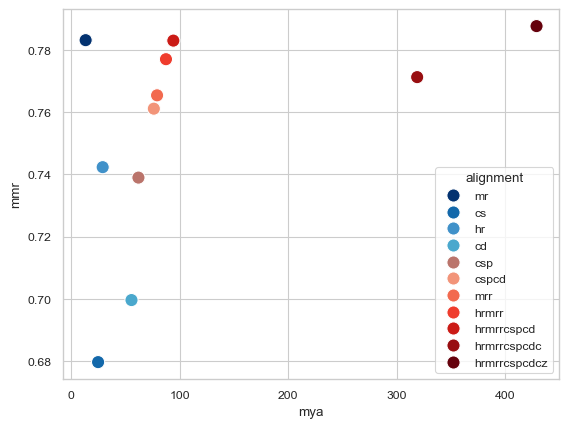

In [24]:
sns.scatterplot(x=count_comparison_df["mya"], y=count_comparison_df["mmr"], hue=merged_df.alignment,palette=list(colors_sorted.values()),s=90)

<Axes: xlabel='mya', ylabel='mmr'>

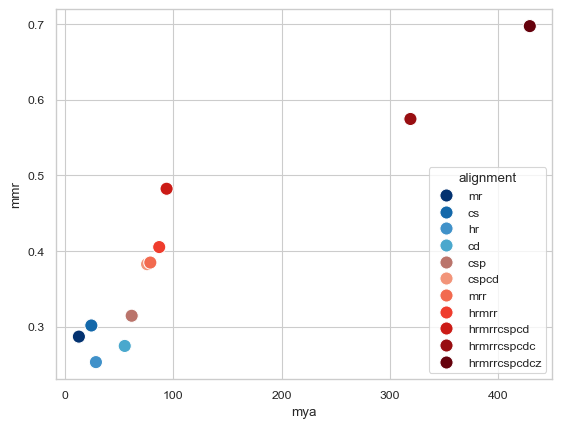

In [25]:
sns.scatterplot(x=rdm_count_comparison_df["mya"], y=rdm_count_comparison_df["mmr"], hue=merged_df.alignment,palette=list(colors_sorted.values()),s=90)

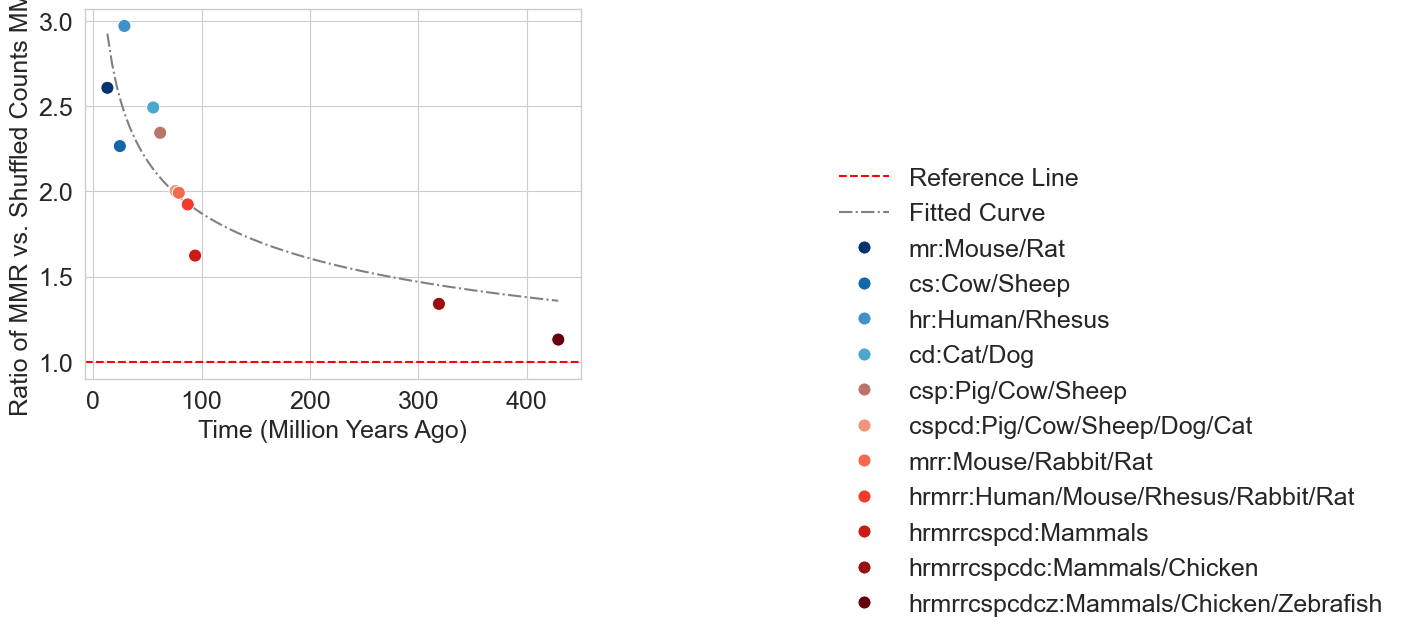

In [12]:
def power_law(x, a, b):
    return a*np.power(x, b)

x_data = merged_df["mya"]
y_data = merged_df["mmr_ratio"]

# plt.figure(figsize=(15, 11)) 

# Fit the data to the exponential decay function
params, covariance = curve_fit(power_law, x_data, y_data)

# Extract the parameter estimates and standard deviations
a, b = params
a_std, b_std = np.sqrt(np.diag(covariance))

# Generate the fitted curve and confidence interval curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = power_law(x_fit, a, b)


plt.axhline(y=1, color='r',linestyle="--",label='Reference Line',linewidth=1.5)
sns.lineplot(x=x_fit, y=y_fit, color='grey', linestyle="-.",label='Fitted Curve',linewidth=1.5,zorder=1)

# Scatter plot for data points
sns.scatterplot(x=merged_df["mya"], y=merged_df["mmr_ratio"], hue=merged_df.alignment,palette=list(colors_sorted.values()),s=90)

# Add labels and legend
plt.xlabel("Time (Million Years Ago)",fontsize=18)
plt.ylabel("Ratio of MMR vs. Shuffled Counts MMR",fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f"{label}:{alignment_code_to_species_legend[label]}" if label in alignment_code_to_species_legend.keys() else label for label in labels]
plt.legend(handles=handles[:], labels=labels[:],bbox_to_anchor=(1.5, 0.6), borderaxespad=0,frameon=False,fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)

# plt.savefig("images/count_mmr_fitted.png", bbox_inches='tight')
plt.show()

In [18]:
def power_law(x, a, b):
    return a * np.power(x, b)

# plt.figure(figsize=(15, 11)) 

x_data = merged_df["mya"]
y_data = merged_df["ard_ratio"]

# Fit the data to the exponential decay function
params, covariance = curve_fit(power_law, x_data, y_data)

# Extract the parameter estimates and standard deviations
a, b= params
a_std, b_std = np.sqrt(np.diag(covariance))

# Generate the fitted curve and confidence interval curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = power_law(x_fit, a, b)

# Plot using seaborn for styling
plt.axhline(y=1, color='r',linestyle="--",label="Reference Line")
sns.lineplot(x=x_fit, y=y_fit, color='grey', linestyle="-.",label="Fitted line")

# Scatter plot for data points
sns.scatterplot(x=merged_df["mya"], y=merged_df["ard_ratio"], hue=merged_df.alignment,palette=list(colors_sorted.values()),s=100)

# Add labels and legend
plt.xlabel("Time (Million Years Ago)",fontsize=18)
plt.ylabel("Ratio of ARD vs. Shuffled Counts ARD",fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f"{label}:{alignment_code_to_species_legend[label]}" if label in alignment_code_to_species_legend.keys() else label for label in labels]
plt.legend(handles=handles[:], labels=labels[:],bbox_to_anchor=(1.5, 0.6), borderaxespad=0,frameon=False,fontsize=18)
# plt.savefig("images/count_ard_fitted.png", bbox_inches='tight')
plt.show()

KeyError: 'ard_ratio'

R^2 for Exponential Decay: 0.9951
R^2 for Power Law: 0.9432
R^2 for Logarithmic: 0.9936
R^2 for Polynomial: 0.9913


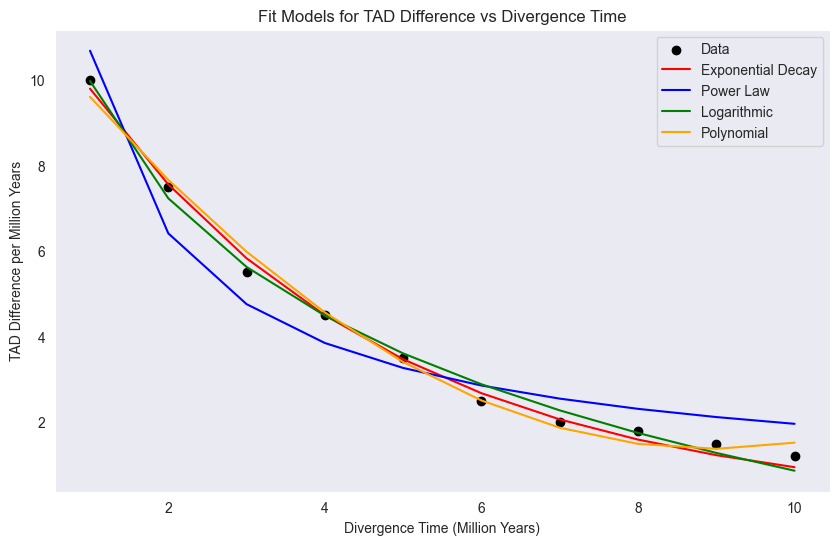

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Example data
# Species pairs with columns: species1, species2, divergence_time, TAD_diff_per_million_year
data = {
    'species1': ['A', 'A', 'B', 'B', 'C'],
    'species2': ['B', 'C', 'C', 'D', 'D'],
    'divergence_time': [50, 100, 70, 120, 150],  # Example divergence times in million years
    'TAD_diff_per_million_year': [0.2, 0.5, 0.3, 0.6, 0.7]  # Example TAD differences per Myr
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Scatter plot: Divergence Time vs TAD Difference per Million Year
plt.figure(figsize=(10, 6))
plt.scatter(df['divergence_time'], df['TAD_diff_per_million_year'], color='blue', alpha=0.7)
plt.xlabel('Divergence Time (Million Years)')
plt.ylabel('TAD Difference per Million Years')
plt.title('TAD Difference per Million Year vs Divergence Time')

# # Fit a linear regression line
# slope, intercept, r_value, p_value, std_err = linregress(df['divergence_time'], df['TAD_diff_per_million_year'])
# plt.plot(df['divergence_time'], intercept + slope * df['divergence_time'], color='red', label=f'Linear fit (R² = {r_value**2:.3f})')
# plt.legend()

# Display plot
plt.show()

# Output correlation statistics
print(f"Correlation coefficient (R): {r_value:.3f}")
print(f"p-value: {p_value:.3f}")


In [22]:
# Y = count_comparison_df[["alignment",'mmr']].copy()
# Y['mmr'] = Y['mmr'] * 100 
# 
# observed_mmr = count_comparison_df[["alignment",'mmr']]
# shuffled_mmr = rdm_count_comparison_df[["alignment",'mmr']]
# X = observed_mmr['mmr'] / shuffled_mmr['mmr']
# X["alignment"]= rdm_count_comparison_df["alignment"]

In [26]:
# Y = count_comparison_df[["alignment",'ard']].copy()
# Y['ard'] = Y['ard'] * 100 
# print(Y)
# 
# observed_mmr = count_comparison_df[["alignment",'ard']]
# shuffled_mmr = rdm_count_comparison_df[["alignment",'ard']]
# X = observed_mmr['ard'] / shuffled_mmr['ard']
# # X["alignment"]= rdm_count_comparison_df["alignment"]
# X

In [15]:
# Observed MMR
observed_mmr = count_comparison_df['mmr'].mean()
observed_mmr
# Distribution of shuffled MMRs (from 1000 random permutations)
shuffled_mmr_distribution = np.concatenate(rdm_count_comparison_df['mmr_distr'].values)

# # Calculate the p-value
# p_value = (shuffled_mmr_distribution >= observed_mmr).mean()
# print(f"p-value: {p_value:.5f}")

In [28]:
# tad_sb_df.loc[tad_sb_df.aln.isin(['Alignment29'])]

In [16]:
observed_mean = count_comparison_df["ard"].values[2]
permuted_means = rdm_count_comparison_df['ard_distr'].values[2]
observed_mean,permuted_means

(0.3218810961896406,
 [1.3779244356263443,
  1.3282474265775377,
  1.3691926288971095,
  1.3002052995975932,
  1.326210499841122,
  1.472774153041899,
  1.4365507301315767,
  1.2738225314911795,
  1.3304011076266675,
  1.4756865613289687])

In [17]:
num_permutations = 10
extreme_count = np.sum(permuted_means >= observed_mean)  # For a one-tailed test
extreme_count

10

In [18]:
p_value = (extreme_count + 1) / (num_permutations + 1)
print(f"Observed Mean: {observed_mean}")
print(p_value)
if p_value<0.05 :print(f"P-Value: {p_value}")

Observed Mean: 0.3218810961896406
1.0


NameError: name 'merged_df' is not defined

NameError: name 'merged_df' is not defined

<Figure size 1500x1100 with 0 Axes>

In [34]:
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,11))
# fig.subplots_adjust(wspace=0.06)  # adjust space between axes
# 
# ax1.axhline(y=1, color='r',linestyle="--")
# ax2.axhline(y=1, color='r',linestyle="--",label="Reference Line")
# 
# # plot the same data on both axes
# sns.scatterplot(data=merged_df, x="mya", y="ard_ratio",hue=colors_sorted.keys(),ax=ax1,legend=False,palette=list(colors_sorted.values()),s=100)
# sns.scatterplot(data=merged_df, x="mya", y="ard_ratio",hue=colors_sorted.keys(),legend=True,ax=ax2,palette=list(colors_sorted.values()),s=100)
# 
# # zoom-in / limit the view to different portions of the data
# ax1.set_xlim(0, 100) # most of the data
# ax2.set_xlim(290, 450)   # outliers only
# ax1.set_ylim(0, 1.5) # most of the data
# ax2.set_ylim(0, 1.5) # most of the data
# 
# # hide the spines between ax and ax2
# ax1.spines.right.set_visible(False)
# ax1.spines.top.set_visible(False)
# ax2.spines.left.set_visible(False)
# ax2.spines.right.set_visible(False)
# ax2.spines.top.set_visible(False)
# 
# # Now, let's turn towards the cut-out slanted lines.
# d = 1 
# kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
#               linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# ax1.plot([1, 1], [0, 0], transform=ax1.transAxes, **kwargs)
# ax2.plot([0, 0], [0, 0], transform=ax2.transAxes, **kwargs)
# 
# ax1.set_xlabel("                                                                                                     Time (Million Years Ago)",fontsize=18)
# ax1.set_ylabel("Ratio of ARD vs. Shuffled Counts ARD",fontsize=18)
# ax2.set(xlabel="", ylabel="")
# ax1.yaxis.set_tick_params(labelsize=18)
# ax1.xaxis.set_tick_params(labelsize=18)
# ax2.xaxis.set_tick_params(labelsize=18)
# handles, labels = plt.gca().get_legend_handles_labels()
# labels = [f"{label}:{alignment_code_to_species_legend[label]}" if label in alignment_code_to_species_legend.keys() else label for label in labels]
# plt.legend(handles=handles[:], labels=labels[:],bbox_to_anchor=(2, 0.6), borderaxespad=0,frameon=False,fontsize=18)
# # plt.savefig("images/count_ard.png", bbox_inches='tight')
# plt.show()

In [35]:
# fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,11))
# fig.subplots_adjust(wspace=0.06)  # adjust space between axes
# 
# ax1.axhline(y=1, color='r',linestyle="--")
# ax2.axhline(y=1, color='r',linestyle="--",label="Reference Line")
# 
# # plot the same data on both axes
# sns.scatterplot(data=merged_df, x="mya", y="mmr_ratio",hue=merged_df.alignment,ax=ax1,legend=False,palette=list(colors_sorted.values()),s=100)
# sns.scatterplot(data=merged_df, x="mya", y="mmr_ratio",hue=merged_df.alignment,legend=True,ax=ax2,palette=list(colors_sorted.values()),s=100)
# 
# # zoom-in / limit the view to different portions of the data
# ax1.set_xlim(0, 110) # most of the data
# ax2.set_xlim(290, 450)   # outliers only
# 
# # hide the spines between ax and ax2
# ax1.spines.right.set_visible(False)
# ax1.spines.top.set_visible(False)
# ax2.spines.left.set_visible(False)
# ax2.spines.right.set_visible(False)
# ax2.spines.top.set_visible(False)
# 
# # Now, let's turn towards the cut-out slanted lines.
# d = .9  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
#               linestyle="none", color='k', mec='k', mew=1, clip_on=False)
# ax1.plot([1, 1], [0, 0], transform=ax1.transAxes, **kwargs)
# ax2.plot([0, 0], [0, 0], transform=ax2.transAxes, **kwargs)
# 
# ax1.set_xlabel("                                                                                  Time (Million Years Ago)",fontsize=18)
# ax1.set_ylabel("Ratio of MMR vs. Shuffled Counts MMR",fontsize=18)
# ax2.set(xlabel="", ylabel="")
# ax1.yaxis.set_tick_params(labelsize=18)
# ax1.xaxis.set_tick_params(labelsize=18)
# ax2.xaxis.set_tick_params(labelsize=18)
# handles, labels = plt.gca().get_legend_handles_labels()
# labels = [f"{label}:{alignment_code_to_species_legend[label]}" if label in alignment_code_to_species_legend.keys() else label for label in labels]
# plt.legend(handles=handles[:], labels=labels[:],bbox_to_anchor=(2, 0.6), borderaxespad=0,frameon=False,fontsize=18)
# # plt.savefig("images/count_mmr.png", bbox_inches='tight')